[Conceptual Questions]
- Q1: How is the concept of prediction in machine learning broad enough to include tasks such as language translation and self-driving cars?
    - It learns the mapping function and it estimates the expectation.
- Q2: Explain how machine learning can be utilized to identify profitable customers in the context of customer acquisition.
    - Using the given data, we can predict the net_value for the customers and identify they will be profitable for our business.
- Q3: What is the purpose of cross-validation in machine learning, and how does it help in model selection and evaluation?
    - CV helps us evaluate untrained data, so that we can be more certain for new data.
- Q4: Differentiate between a prediction and a policy in the context of machine learning applications in business.
    - Prediction is to find a value with given data with complex equation. Policy is a automatic business deicision.
- Q5: How can machine learning predictions inform more nuanced business decisions beyond binary choices, such as how much to invest in marketing for individual customers?
    - You can classify royal customers, prime group and increase marketing for specific targets...


[Hands-on Practice]
- Check the average net value of the customers to determine if we have enough customers to make a net profit. [Refer to the One Feature Policies Section]
- We hypothesize that while the average net value might be negative across the entire dataset, there could be specific subpopulations, particularly at higher income levels, where the net value is positive. To explore this hypothesis, we'll partition the data into income quantiles and then compute the average net value for each quantile. Similarly, examine the average net value for each region using the same approach as with the income quantiles, and identify the regions where the expected net value is positive. [Refer to the One Feature Policies Section]
- Create your own policy to engage with profitable customers based on the predictions from the Gradient Boosting model. Try both with and without Cross-Validation. [Refer to the Machine Learning Models as Policy Inputs & Cross Validation Section]
- Set up marketing strategies to maximize the return on marketing expenditures using model bands, which segment customers based on profitability. [Refer to the Fine Grain Policy Section]

In [4]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

customer_features = pd.read_csv("customer_features.csv")
print(transactions.shape)
transactions.head()

(10000, 5)


,customer_id,region,income,age,net_value
0,0,30,1025,24,130
1,1,41,1649,26,10
2,2,18,2034,33,-6
3,3,20,1859,35,136
4,4,1,1243,26,-8


In [5]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)
train.shape, test.shape

((7000, 5), (3000, 5))

In [6]:
train["net_value"].mean()

-29.169428571428572

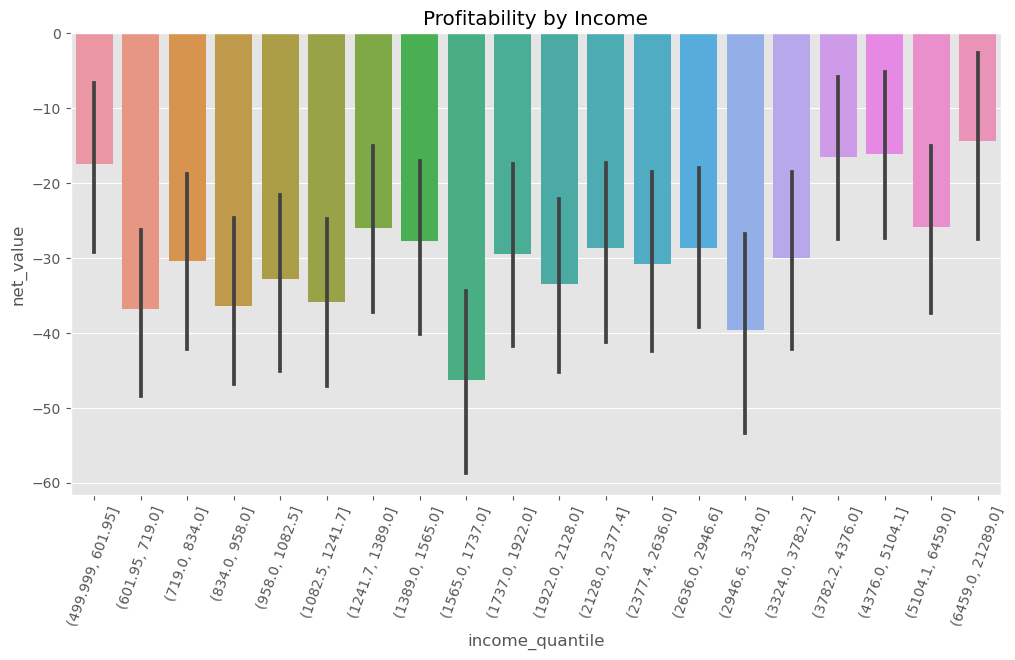

In [7]:
plt.figure(figsize=(12,6))
np.random.seed(123) ## seed because the CIs from seaborn uses boostrap

# pd.qcut create quantiles of a column
sns.barplot(data=train.assign(income_quantile=pd.qcut(train["income"], q=20)), 
            x="income_quantile", y="net_value")
plt.title("Profitability by Income")
plt.xticks(rotation=70);

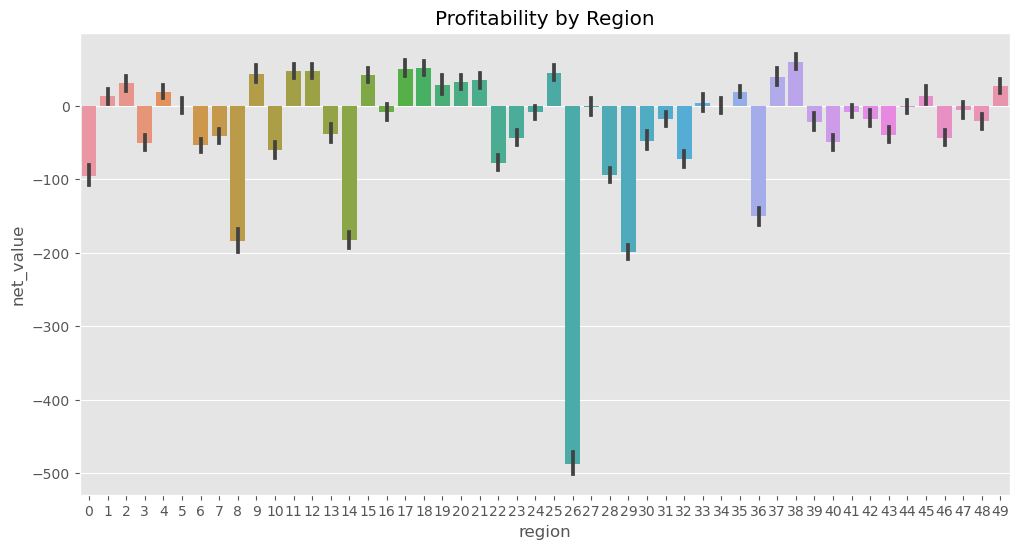

In [8]:
plt.figure(figsize=(12,6))
np.random.seed(123)
region_plot = sns.barplot(data=train, x="region", y="net_value")
plt.title("Profitability by Region");

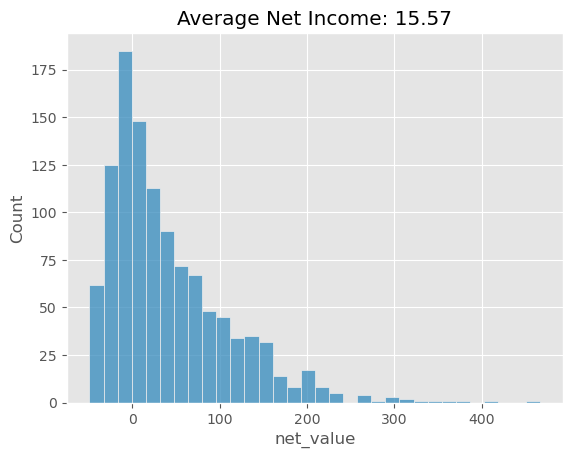

In [10]:
# extract the lower bound of the 95% CI from the plot above
regions_to_net = train.groupby('region')['net_value'].agg(['mean', 'count', 'std'])

regions_to_net = regions_to_net.assign(
    lower_bound=regions_to_net['mean'] - 1.96*regions_to_net['std']/(regions_to_net['count']**0.5)
)

regions_to_net_lower_bound = regions_to_net['lower_bound'].to_dict()
regions_to_net = regions_to_net['mean'].to_dict()

# filters regions where the net value lower bound is > 0.
regions_to_invest = {region: net 
                     for region, net in regions_to_net_lower_bound.items()
                     if net > 0}

regions_to_invest

region_policy = (test[test["region"]
                      # filter regions in regions_to_invest
                      .isin(regions_to_invest.keys())]) 

sns.histplot(data=region_policy, x="net_value")
# average has to be over all customers, not just the one we've filtered with the policy
plt.title("Average Net Income: %.2f" % (region_policy["net_value"].sum() / test.shape[0]));

In [11]:
def encode(df): 
    return df.replace({"region": regions_to_net})

model_params = {'n_estimators': 400,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(123)

reg = ensemble.GradientBoostingRegressor(**model_params)

# fit model on the training set
encoded_train = train[features].pipe(encode)
reg.fit(encoded_train, train[target]);

In [12]:
train_pred = (encoded_train
              .assign(predictions=reg.predict(encoded_train[features])))

print("Train R2: ", r2_score(y_true=train[target], y_pred=train_pred["predictions"]))
print("Test R2: ", r2_score(y_true=test[target], y_pred=reg.predict(test[features].pipe(encode))))

Train R2:  0.7108790300152951
Test R2:  0.6938513063048141


In [13]:
model_policy = test.assign(prediction=reg.predict(test[features].pipe(encode)))

model_policy.head()

,customer_id,region,income,age,net_value,prediction
5952,5952,19,1983,23,21,47.734883
1783,1783,31,914,31,-46,-36.026935
4811,4811,33,1349,25,-19,22.553420
145,145,20,1840,26,55,48.306256
7146,7146,19,3032,34,-17,7.039414


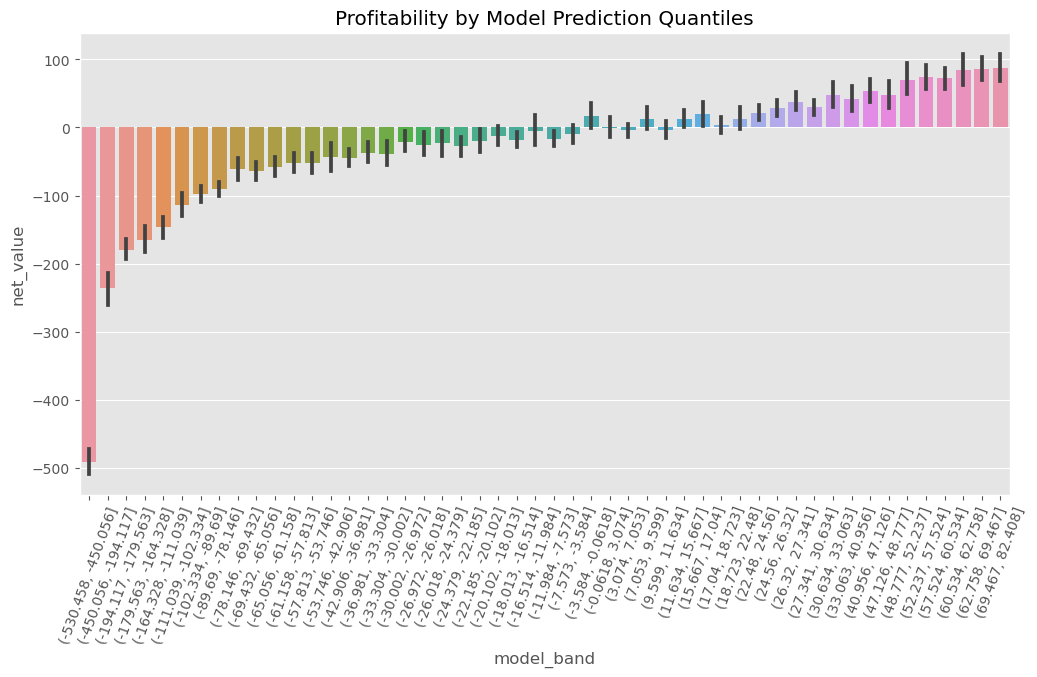

In [14]:
plt.figure(figsize=(12,6))

n_bands = 50
bands = [f"band_{b}" for b in range(1,n_bands+1)]

np.random.seed(123)
model_plot = sns.barplot(data=model_policy
                         .assign(model_band = pd.qcut(model_policy["prediction"], q=n_bands)),
                         x="model_band", y="net_value")
plt.title("Profitability by Model Prediction Quantiles")
plt.xticks(rotation=70);

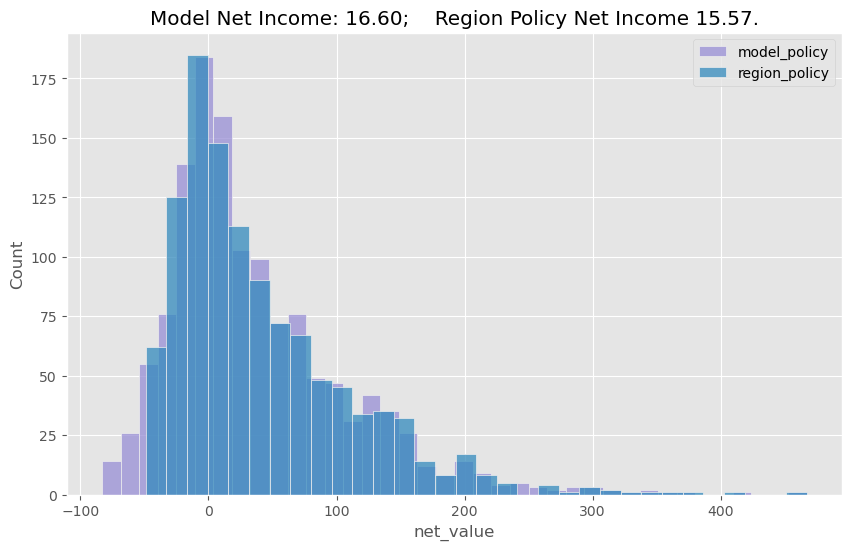

In [15]:
plt.figure(figsize=(10,6))
model_plot_df = (model_policy[model_policy["prediction"]>0])
sns.histplot(data=model_plot_df, x="net_value", color="C2", label="model_policy")

region_plot_df = (model_policy[model_policy["region"].isin(regions_to_invest.keys())])
sns.histplot(data=region_plot_df, x="net_value", label="region_policy")

plt.title("Model Net Income: %.2f;    Region Policy Net Income %.2f." % 
          (model_plot_df["net_value"].sum() / test.shape[0],
           region_plot_df["net_value"].sum() / test.shape[0]))
plt.legend();

In [16]:
def model_binner(prediction_column, bins):
    # find the bins according to the training set
    bands = pd.qcut(prediction_column, q=bins, retbins=True)[1]
    
    def binner_function(prediction_column):
        return np.digitize(prediction_column, bands)
    
    return binner_function
    

# train the binning function
binner_fn = model_binner(train_pred["predictions"], 20)

# apply the binning
model_band = model_policy.assign(bands = binner_fn(model_policy["prediction"]))
model_band.head()

,customer_id,region,income,age,net_value,prediction,bands
5952,5952,19,1983,23,21,47.734883,18
1783,1783,31,914,31,-46,-36.026935,7
4811,4811,33,1349,25,-19,22.553420,15
145,145,20,1840,26,55,48.306256,18
7146,7146,19,3032,34,-17,7.039414,13


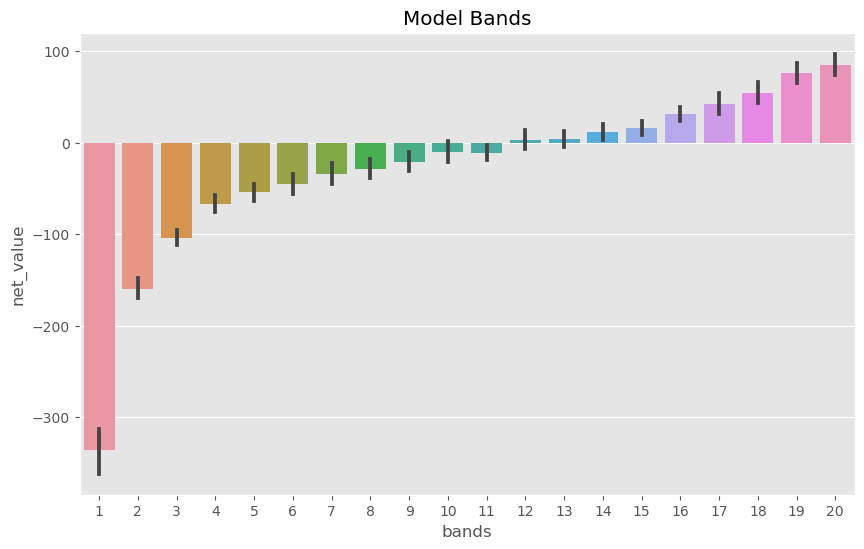

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(data=model_band, x="bands", y="net_value")
plt.title("Model Bands");

In [19]:
mkt_investments_i = train_pred["predictions"] * 0.3

mkt_investments_i

4847    14.744591
9992    -5.504651
4621   -62.072560
5774   -18.721271
9294    12.998790
          ...    
5876    20.893610
866      0.007921
7696   -11.809127
74       7.642787
338     -2.878243
Name: predictions, Length: 7000, dtype: float64